In [20]:
import torch
import numpy as np
import pandas as pd
import json
from ipywidgets import interact, FloatSlider, Button, HBox, VBox, HTML, Layout, Output
from joblib import load
from modules.cGAN_samplers import noise_sampler
from modules.functions import decode, calculate_entropy_mixing, data_generator, pymatgen_comp
from modules.plotting import Radar
import matplotlib.pyplot as plt

In [21]:
model = torch.jit.load('saved_cGAN/generator.pt',map_location='cpu')
with open('saved_cGAN/gan_hyperparameters.json','r') as fid:
    gan_hyperparameters = json.load(fid)
selected_props = gan_hyperparameters['selected_props']
latent_dim = gan_hyperparameters['latent_dim']
prop_dim = gan_hyperparameters['prop_dim']
elem_list = gan_hyperparameters['elem_list']

scaler_pipe = load('saved_cGAN/scale_kde_pipe.joblib')

In [106]:
def generate_alloy(prop_arr):
    input_data = np.array(prop_arr).reshape(1,-1).astype('float32')
    scaled_input = torch.from_numpy(scaler_pipe['Scaler'].transform(input_data))
    noise = torch.from_numpy(noise_sampler(1,latent_dim))
    with torch.no_grad():
        generated = model(noise,scaled_input).numpy()
    composition = decode(generated[0], elem_list)
    dict_generated = {'Composition':composition.reduced_formula,
            'composition_arr':generated[0]}
    for i,prop in enumerate(selected_props):
        if prop == 'delta_S':
            dict_generated[prop] = calculate_entropy_mixing(composition).item()
        else:
            model_surrogate = load(f'saved_surrogates/surrogate_{prop}.joblib')
            dict_generated[prop] = model_surrogate.predict(generated).item()
    return dict_generated
    print(f'Generated composition with given conditions : {composition}')
    print(pd.DataFrame(res, columns=selected_props))


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

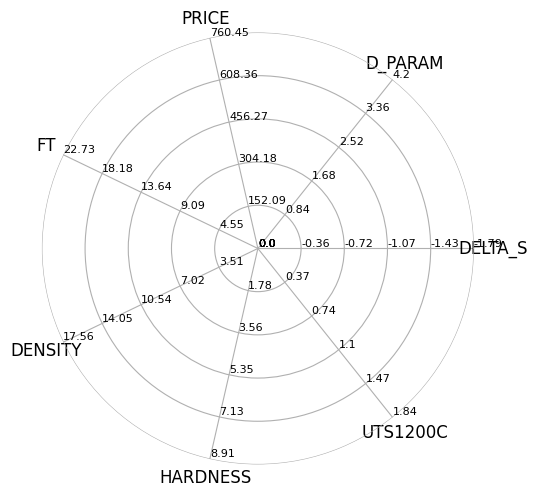

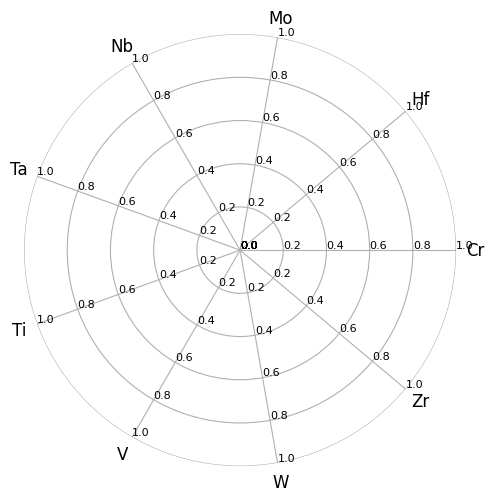

In [23]:
demo_df = pd.read_csv('dataset/demo_dataset_true.csv',index_col=0)
dict_of_props = {}

for p in selected_props:
    vals = demo_df.loc[:,p].values
    dict_of_props[p.lower()] = {'min':np.round(np.min(vals),2),
                        'max':np.round(np.max(vals),2),
                        'value':np.round((np.min(vals)+np.max(vals))/2,2),
                        'step':0.01,
                        'description':p.upper()
                        }
    
comp, prop = Output(), Output()
fig1 = plt.figure()
fig2 = plt.figure()


with prop:
        tit = [x.upper() for x in selected_props]
        labels = []
        steps = []
        for p in dict_of_props.keys():
            if p!='delta_s':
                linsp, step = np.linspace(0,dict_of_props[p]['max'],6, retstep=True)
            else:
                linsp, step = np.linspace(0,dict_of_props[p]['min'],6, retstep=True)
            labels.append(np.round(linsp,2))
            steps.append(step)
        radar_prop= Radar(tit, labels)

with comp:
    
    tit = elem_list
    labels = []
    for el in tit:
        linsp = np.linspace(0,1,6)
        labels.append(np.round(linsp,2))
    radar_comp = Radar(tit,labels)


list_of_sliders = [FloatSlider(**params) for params in dict_of_props.values()]

reset_button = Button(
    description='Reset',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Reset the slider values'
)

generate_button = Button(
    description='Generate',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Generate HEA composition with selected conditions'
)


def reset(_):
    for slider in list_of_sliders:
        slider.value = dict_of_props[slider.description.lower()]['value']
    comp.clear_output()
    prop.clear_output()

# Importing required modules
import ipywidgets as widgets
import matplotlib.pyplot as plt

# Function for plotting figures
def plot_function(_):
    # Update the three slider variables based on user input
    arr = np.zeros(len(list_of_sliders))
    for i,sl in enumerate(list_of_sliders):
        arr[i] = sl.value
    # Create the figure
    r_new = []
    for i,p in enumerate(dict_of_props.keys()):
        if p!='delta_s':
            r_new.append(np.round((arr[i]/dict_of_props[p]['max']*5),2))
        else:
            r_new.append(np.round((arr[i]/dict_of_props[p]['min']*5),2))
    print(r_new)
    radar_prop.plot(r_new)
    fig1.canvas.draw_idle()

    gen = generate_alloy(arr)
    print(gen)

   

# Create the three sliders with range and default values specified

# Create a button widget
reset_button.on_click(reset)
generate_button.on_click(plot_function)

# Connect the event handler to the "on_click" event of the button

# Display all the widgets 

controls = widgets.VBox([*list_of_sliders, generate_button,reset_button])
plots = widgets.HBox([comp,prop])
widgets.HBox([controls,plots])

Button(description='Click Me!', style=ButtonStyle())

Button(description='Erase', style=ButtonStyle())

Output()

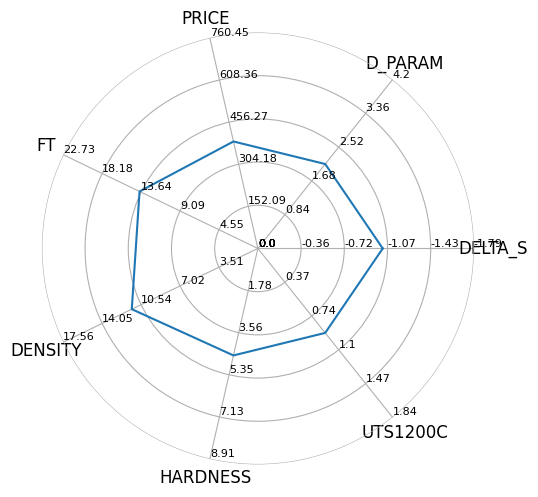

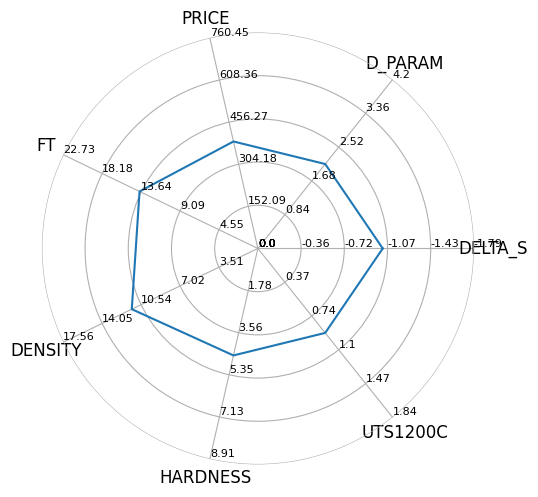

In [41]:

class Radar(object):
    def __init__(self, title, labels, rect=None):
        if rect is None:
            rect = [0.05, 0.05, 0.9, 0.9]

        self.n = len(title)
        self.angles = np.arange(0, 360, 360.0/self.n)
        self.figure = plt.figure()
        self.axes = [self.figure.add_axes(rect, projection='polar', label='axes%d' % i) for i in range(self.n)]

        self.ax = self.axes[0]
        self.ax.set_thetagrids(self.angles, labels=title, fontsize=12)

        for ax in self.axes[1:]:
            ax.patch.set_visible(False)
            ax.grid(False)
            ax.xaxis.set_visible(False)

        for ax, angle, label in zip(self.axes, self.angles, labels):
            ax.set_rgrids(range(0, 6), angle=angle, labels=label,fontsize = 8)
            ax.spines['polar'].set_visible(False)
            ax.set_ylim(0, 5)
            
            
    def plot(self, values, *args, **kw):
        #self.figure.clear()
        angle = np.deg2rad(np.r_[self.angles, self.angles[0]])
        values = np.r_[values, values[0]]
        self.ax.plot(angle, values, *args, **kw)

from IPython.display import display
button = widgets.Button(description="Click Me!")
button2 = widgets.Button(description="Erase")
output = widgets.Output()

display(button, button2, output)



def on_button_clicked(b):
    with output:
        output.clear_output()
        tit = [x.upper() for x in selected_props]
        labels = []
        steps = []
        for p in dict_of_props.keys():
            if p!='delta_s':
                linsp, step = np.linspace(0,dict_of_props[p]['max'],6, retstep=True)
            else:
                linsp, step = np.linspace(0,dict_of_props[p]['min'],6, retstep=True)
            labels.append(np.round(linsp,2))
            steps.append(step)
        radar_prop = Radar(tit, labels)
        r_new = [2.89, 2.5, 2.54, 3.04, 3.24, 2.54, 2.5]
        radar_prop.plot(r_new)

def reset(_):
    output.clear_output()

button.on_click(on_button_clicked)
button2.on_click(reset)

In [63]:
import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import widgets
from IPython.display import display,clear_output

plt.ioff()
ax=plt.gca()

out=widgets.Output()
button=widgets.Button(description='Next')
vbox=widgets.VBox(children=(out,button))
display(vbox)

out = widgets.Output()
with out: 
    df = pd.DataFrame({'A':[],'B':[]})

def click(self, b):
    
    
    with out:
        a = 0
        b = 0
        a+=1
        b-=1
        df_temp = pd.DataFrame({'A':[a],'B':[b]})
        df_out = pd.concat((df,df_temp))
        clear_output(wait=True)
        print(df_out)
        df = df_out
    vbox.children = [button, out]

button.on_click(click)
click()

In [163]:
import ipywidgets as widgets
import pandas as pd
import plotly.graph_objects as go


demo_df = pd.read_csv('dataset/demo_dataset_true.csv',index_col=0)
df = pd.DataFrame(columns=demo_df.columns)
dict_of_props = {}



for p in selected_props:
    vals = demo_df.loc[:,p].values
    dict_of_props[p.lower()] = {'min':np.round(np.min(vals),2),
                        'max':np.round(np.max(vals),2),
                        'value':np.round((np.min(vals)+np.max(vals))/2,2),
                        'step':0.01,
                        'description':p.upper()
                        }
class record():
    def __init__(self):
        self.objects = [FloatSlider(**params) for params in dict_of_props.values()]
        self.reset_button = Button(description='Reset',disabled=False,button_style='',tooltip='Reset the slider values')
        self.reset_button.on_click(self.on_reset_button_clicked)
        self.generate_button = Button(description='Generate',disabled=False,button_style='',tooltip='Generate HEA composition with selected conditions')
        self.generate_button.on_click(self.on_generate_button_clicked)
        self.output = Output()
        display(*self.objects,self.reset_button, self.generate_button, out)
        self.fig = go.Figure()
    

    def on_generate_button_clicked(self,b):
        arr = np.zeros(len(self.objects))
        for i,sl in enumerate(self.objects):
            arr[i] = sl.value
        data = generate_alloy(arr)
        df.loc[len(df)]=data

        #composition
        
        with out:
            
            clear_output(True)
            
            print(df.shape[0])
            for i in range(df.shape[0]):
                
                self.fig.add_trace(go.Scatterpolar(
      r=data['composition_arr'],
      theta=elem_list,
      fill='toself',
      name=df['Composition'][i]
))
                
            self.fig.update_layout(
    title={
        'text': "Composition",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
            names = set()
            self.fig.for_each_trace(lambda trace:trace.update(showlegend=False) if (trace.name in names) else names.add(trace.name))
            self.fig.show()

        

    
    def on_reset_button_clicked(self,b):
        df.drop(df.index, inplace=True)
        with out:
            clear_output()
        print(df)
        self.fig.data = []
        #df = pd.DataFrame(columns=demo_df.columns)
        #print(df)
        
        
r =record()

FloatSlider(value=-1.03, description='DELTA_S', max=-0.28, min=-1.79, step=0.01)

FloatSlider(value=2.1, description='D_PARAM', max=4.2, step=0.01)

FloatSlider(value=386.62, description='PRICE', max=760.45, min=12.8, step=0.01)

FloatSlider(value=13.83, description='FT', max=22.73, min=4.92, step=0.01)

FloatSlider(value=11.37, description='DENSITY', max=17.56, min=5.17, step=0.01)

FloatSlider(value=4.52, description='HARDNESS', max=8.91, min=0.13, step=0.01)

FloatSlider(value=0.92, description='UTS1200C', max=1.84, step=0.01)

Button(description='Reset', style=ButtonStyle(), tooltip='Reset the slider values')

Button(description='Generate', style=ButtonStyle(), tooltip='Generate HEA composition with selected conditions…

Output(outputs=({'name': 'stdout', 'text': '1\n', 'output_type': 'stream'}, {'output_type': 'display_data', 'd…

Empty DataFrame
Columns: [Composition, delta_S, d_param, price, FT, density, hardness, uts1200C]
Index: []
